In [1]:
%matplotlib notebook
import argparse
import numpy as np
import uproot as uproot
#import uproot
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from matplotlib.colors import LogNorm
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import time

In [2]:
#### Specify a file by specifying the path to the file ####
file_path = './kaon.root'

### Since the event is generated at 0,0,0, we will add an offset
xoffset = 0
yoffset = 0
zoffset = 0

In [3]:
#### Detector Dimensions (in cm) #####
xDimension = 300.
yDimension = 200.
zDimension = 200.

### Define the size of pixels (in cm) ###
PixelPitch = 4.0

### Compute the number of pixels in each direction ####
nZPixels = int(zDimension/PixelPitch)
nYPixels = int(yDimension/PixelPitch)
nXPixels = int(xDimension/PixelPitch)
nPhotonsPerPixel = int(100000)

### Make an array of zeros for all the pixels ###
PixelMapYZ = np.zeros([nYPixels, nZPixels], dtype = float)

PixelTimeMapYZ = np.zeros([nYPixels, nZPixels], dtype = float)

#4D array [YPixel, ZPixel, PhotonNumber, Time]
#PixelTimeMapYZ = []

### Trying to create a 4-d array from this code 
#https://www.kite.com/python/answers/how-to-create-a-3d-array-in-python
#for i in range (nYPixels):
#    PixelTimeMapYZ.append([])
    
#    for j in range(nZPixels):
#        PixelTimeMapYZ[i].append([])

### Define the Pixel Plane Orientation ###
planeNormalYZ = np.array([1, 0, 0]) #Unit vector in x
planePointYZ = np.array([0, 1, 1]) #Any point on the YZ plane


<IPython.core.display.Javascript object>


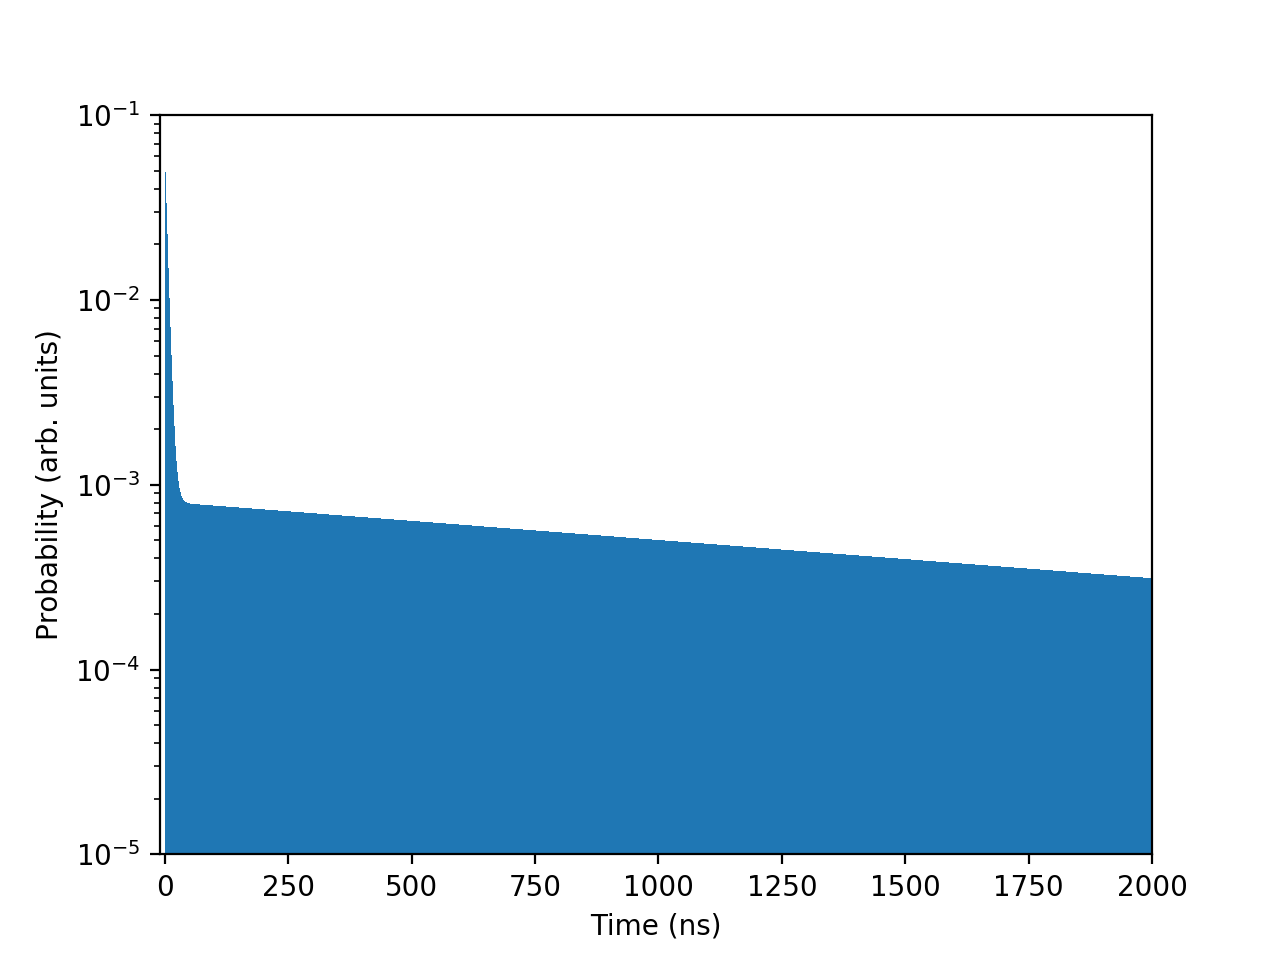

In [4]:
### Setting up details about the scintillation light functions we will need ###
### to do the time of arrival for the photons

### an array of times (in nanoseconds)
time = []
### an array of weights based on the scrintillation model
weight = []

### time constants for the fast and slow scintillation coming from the singlet and triplet states (in ns)
tau_fast = 5.0
tau_slow = 2100.

### and index to loop over ###
t=0.

### We fill out the time to 2000 ns
while t < 2000:
    # Using https://arxiv.org/pdf/2012.06527.pdf suggests 15% of the light is in the singlet state
    # and 85% is in the triplet state
    weight.append((0.15/tau_fast)*math.exp(-t/tau_fast) + (0.85/tau_slow)*math.exp(-t/tau_slow))
    
    ### Append the time variable
    time.append(t)
    
    ### Iterate in 0.1 ns steps (this may be too fine a step)
    t+=0.1
    
### This generates the weighted function of the scintillation light ####
fig = plt.figure()
histo, bins, ignored1 = plt.hist(time, 10000, density=False, weights = weight)
plt.xlabel("Time (ns)")
plt.ylabel("Probability (arb. units)")
plt.yscale('log')
plt.xlim(-10, 2000)
plt.ylim(1E-5, 0.1)
plt.show()

In [5]:
### Defining a function which calculates the intersection point ###
def LinePlaneCollision(planeNormal, planePoint, rayDirection, rayPoint, epsilon=1e-6):
 
    ndotu = planeNormal.dot(rayDirection)
    if abs(ndotu) < epsilon:
        #raise RuntimeError("no intersection or line is within plane")
        print('No intersection or line is within the plane')
        Psi = []
        Psi.append(0.)
        Psi.append(0.)
        Psi.append(0.)
        return Psi
 
    w = rayPoint - planePoint
    si = -planeNormal.dot(w) / ndotu
    Psi = w + si * rayDirection + planePoint
    return Psi

In [6]:
def NormalizedDistanceVector(Point1, Point2):
    ### Define the vector connecting the two points ###
    distance = [Point1[0] - Point2[0], Point1[1] - Point2[1], Point1[2] - Point2[2]]
    ### Normalize the vector ####
    norm = math.sqrt(distance[0] ** 2 + distance[1] ** 2 + distance[2] ** 2)
    
    ### Calculate the Normalized Distance Vector from this point ###
    direction = [distance[0] / norm, distance[1] / norm, distance[2] / norm]
    
    return direction
    

In [7]:
def Distance (Point1, Point2):
    ### Define the vector connecting the two points ###
    vector = [Point1[0] - Point2[0], Point1[1] - Point2[1], Point1[2] - Point2[2]]
    ### Normalize the vector ####
    norm = math.sqrt(vector[0] ** 2 + vector[1] ** 2 + vector[2] ** 2)
    
    return norm

In [8]:
def DotProduct(DistanceNormalVector, PlaneNormalVector):
    inner = np.inner(DistanceNormalVector, PlaneNormalVector)
    return inner

In [9]:
# Based on code from https://nusoft.fnal.gov/larsoft/doxsvn/html/OpFastScintillation_8cxx_source.html#l01595
# and https://nusoft.fnal.gov/larsoft/doxsvn/html/OpFastScintillation_8cxx_source.html#l02075
#def SolidAngleCalculation(PixelCenterPositionX, PixelCenterPositionY, ScintPoint):
#    aa = PixelCenterPositionX / (2 * ScintPoint)
#    bb = PixelCenterPositionY / (2 * ScintPoint)
#    aux = (1. + aa * aa + bb * bb) / ((1. + aa * aa) * (1. + bb * bb))
    
#    Rectangle_SolidAngle = 4* math.acos(math.sqrt(aux))

In [10]:
### Open the file and then read out the data ####
with uproot.open(file_path) as f:
    #--------------------------------------------------------------------------
    # get metadata from ROOT file
    #--------------------------------------------------------------------------

    metadata = f['metadata']

    #--------------------------------------------------------------------------
    # get event tree from ROOT file
    #--------------------------------------------------------------------------

    tree = f['event_tree']

    # list of branches that we want to access
    branches = [

        # event number
        'event',
        
        # generator info
        'generator_initial_number_particles', 'generator_initial_particle_pdg_code',
        'generator_initial_particle_px', 'generator_initial_particle_py', 'generator_initial_particle_pz',
        'generator_initial_particle_energy',
        'generator_final_number_particles', 'generator_final_particle_pdg_code',
        'generator_final_particle_px', 'generator_final_particle_py', 'generator_final_particle_pz',
        'generator_final_particle_energy',

        # MC particle information [Q_PIX_GEANT4]
        'particle_track_id', 'particle_pdg_code',
        'particle_mass', 'particle_initial_energy',

        # MC hit information [Q_PIX_GEANT4]
        'number_hits','hit_energy_deposit', 'hit_track_id', 'hit_process_key',
        'hit_start_x', 'hit_start_y', 'hit_start_z', 'hit_start_t','hit_process_key',
        'hit_end_x', 'hit_end_y', 'hit_end_z', 'hit_end_t',


    ]
    
     #--------------------------------------------------------------------------
    # iterate through the event tree
    #--------------------------------------------------------------------------
    for arrays in tree.iterate(branches=branches, namedecode='utf-8'):
        # get event number array
        event_array = arrays['event']
        
        # get number of events
        number_events = len(event_array)
        
        
        # get neutrino initial state particle (fsp) info
        nu_isp_number = arrays['generator_initial_number_particles']
        nu_isp_pdg = arrays['generator_initial_particle_pdg_code']
        nu_isp_px = arrays['generator_initial_particle_px']
        nu_isp_py = arrays['generator_initial_particle_py']
        nu_isp_pz = arrays['generator_initial_particle_pz']
        nu_isp_KE = arrays['generator_initial_particle_energy']
        
        # get neutrino final state particle (fsp) info
        nu_fsp_number = arrays['generator_final_number_particles']
        nu_fsp_pdg = arrays['generator_final_particle_pdg_code']
        nu_fsp_px = arrays['generator_final_particle_px']
        nu_fsp_py = arrays['generator_final_particle_py']
        nu_fsp_pz = arrays['generator_final_particle_pz']
        nu_fsp_KE = arrays['generator_final_particle_energy']
        
        # get the deposited energy info
        Edep_number = arrays['number_hits']
        Edep_dq = arrays['hit_energy_deposit']
        Edep_x = arrays['hit_start_x']
        Edep_y = arrays['hit_start_y']
        Edep_z = arrays['hit_start_z']
        Edep_trkID = arrays['hit_track_id']
        Edep_PDG = arrays['hit_process_key']
        Edep_G4Index = ['hit_track_id']


In [11]:
### Variables for Plotting the image ###
XEdep = []
YEdep = []
ZEdep = []
QEdep = []
time_allphotons = []

### Global Photon Counter
npho = 0


#############################
### Loop over the events ####
#############################
#for idx in range(number_events): 
idx = 0 ### Note: idx == 2 is an interesting event for file 0000.root
while(idx < 1):
    
    for b in range(nu_isp_number[idx]):
        print('Generator ', b, ' PDG: ', nu_isp_pdg[idx][b], ' Energy: ', nu_isp_KE[idx][b])
        
    for a in range(nu_fsp_number[idx]):
        print('FSP', a, ' PDG: ', nu_fsp_pdg[idx][a], ' Energy: ', nu_fsp_KE[idx][a])
    
    Edep = 0
    ### Number of hits for this event ###
    nMC_Hits = Edep_number[idx]
    ### Loop over all the deposited energy points for this event ####
    for Edep in range(nMC_Hits):
    #while(Edep < int(Edep_number[idx]/50) ):
        
        ### Skip energy deposits that are outside the detector ###
        if( (Edep_x[idx][Edep] + xoffset) < 0 or (Edep_x[idx][Edep] + xoffset) >  xDimension or
            (Edep_y[idx][Edep] + yoffset) < 0 or (Edep_y[idx][Edep] + yoffset) >  yDimension or
            (Edep_z[idx][Edep] + zoffset) < 0 or (Edep_z[idx][Edep] + zoffset) >  zDimension ):
            continue
        
        XEdep.append(Edep_x[idx][Edep] + xoffset)
        YEdep.append(Edep_y[idx][Edep] + yoffset)
        ZEdep.append(Edep_z[idx][Edep] + zoffset)
        QEdep.append(Edep_dq[idx][Edep])
        
        
        #print('X: ', Edep_x[idx][Edep] + xoffset, ' Y: ', Edep_y[idx][Edep] + yoffset, ' Z: ', Edep_z[idx][Edep] + zoffset)
        
        ### Taking the "W-Value" for scintillation from https://lar.bnl.gov/properties/#scint
        ### we estimate 19.5 eV / photon, so we can easily calculate the number of photons 
        ### produced by each energy deposition (note: we have to convert the units of Hit_Energy
        ### to eV from MeV)
        n_photons_raw = int(Edep_dq[idx][Edep]*1E6 / 19.5) ### note: I am using the 'int' function to round
        #print(n_photons_raw)
        
        if((Edep%10)==0):
            print("Current Hit ", Edep, " of ", Edep_number[idx])
        
        ### Zero the pixel address ###
        zloc = 0.
        column = 0
        yloc = 0.
        row = 0
        dis = 0.
        # loop over all the pixels in z dimensions
        while zloc < zDimension:
            # loop over all the pixels in the y dimension for a given z dimension
            
            
            while yloc < yDimension:
                
                # Location of the pixel (in cm)
                pixelLocation = (0, yloc, zloc)
                
                # Location of the Energy Deposition 
                EDepLocation = (Edep_x[idx][Edep] + xoffset, Edep_y[idx][Edep] + yoffset, Edep_z[idx][Edep] + zoffset)
                
                ### Get the Normalized Distance Vector
                NormDVec = NormalizedDistanceVector(pixelLocation, EDepLocation)
                
                ### Calculate the Euclidian Distance 
                dis = Distance(pixelLocation, EDepLocation)
                #print(dis)
                
                ### Calculate little Omega (solid angle assuming on axis)
                
                pixelPitchSquared =  PixelPitch*PixelPitch
                
                numerator = pixelPitchSquared
                denomenator = pixelPitchSquared + (4*dis*dis)
                littleOmega = 4* np.arcsin(numerator / denomenator)
                #print('littleOmega: ',littleOmega)
                ### Calculate the solid angle (taking into acount the angle between the pixel)
                Dprod = DotProduct(NormDVec,planeNormalYZ)
                #print(Dprod)
                Omega = abs(littleOmega * DotProduct(NormDVec,planeNormalYZ))
                #print('Omega: ', Omega) 
                
                #print('Photons: ', (Omega * n_photons_raw)/(4*3.14159))
                #print('w/absorption: ', np.exp(-dis/20000) * ((Omega * n_photons_raw)/(4*3.14159)))
                
                
                ### Put this into a pixel map ###
                #row = int(yloc*10 / 4)
                #column = int(zloc*10 / 4)
                PhotonCount = ((Omega * n_photons_raw)/(4*3.14159))
                PixelMapYZ[row,column] += int(PhotonCount)
                #print('row: ', row, ' column: ', column, 'photons: ', int(PhotonCount))
                #Bump the y-location
                
                ### Get the number of photons for this pixel pad
                
                
                #https://stackoverflow.com/questions/17821458/random-number-from-histogram
                bin_midpoints = bins[:-1] + np.diff(bins)/2
                cdf = np.cumsum(histo)
                #print('cdf: ', cdf)
                cdf = cdf / cdf[-1]
                ### Generate PhotonCount number of scintillation times
                values = np.random.rand(int(PhotonCount))
                #print('values: ', values)
                value_bins = np.searchsorted(cdf, values)
                random_from_cdf = bin_midpoints[value_bins]
                
                #print(random_from_cdf)
                
                nprompt_photons = 0
                ### Loop over all the photons generated at this time ####
                while npho < int(PhotonCount):
                    #### Time is the distance divided by the velocity (11.23 cm / ns) plus
                    ### the scintillation time
                    time = ( dis/11.23 ) + random_from_cdf[npho]
                    
                    #print('time: ',time)
                    if(time < 50):
                        nprompt_photons+=1
                    time_allphotons.append(time)
                    
                    #PixelTimeMapYZ[row][column][npho].append(time)
                    #PixelTimeMapYZ[row][column][npho] = time
                    
                    npho+=1
                
                PixelTimeMapYZ[row][column]+=nprompt_photons
                
                npho=0
                yloc += 4.
                row+=1
            # Bump the z-location    
            zloc += 4.
            column +=1
            # zero the y location
            yloc = 0
            row = 0
        #Edep+=1
    idx+=1
        
        ### Taking the "W-Value" for scintillation from https://lar.bnl.gov/properties/#scint
        ### we estimate 19.5 eV / photon, so we can easily calculate the number of photons 
        ### produced by each energy deposition (note: we have to convert the units of Hit_Energy
        ### to eV from MeV)
        #n_photons_raw = int(Edep_dq[idx][Edep]*10E6 / 19.5) ### note: I am using the 'int' function to round
        
        
        ### Now we adjust this by the 'ideal' geometric case considered in this paper under equation 3
        # https://arxiv.org/pdf/2010.00324.pdf
        
        # we use line 1640 from this code: 
        #https://nusoft.fnal.gov/larsoft/doxsvn/html/OpFastScintillation_8cxx_source.html
        #hits_geo = math.exp(-1. * distance / fL_abs_vuv) * (solid_angle / (4 * CLHEP::pi)) * Nphotons_created
        
        

Generator  0  PDG:  321  Energy:  878.0594732303618
FSP 0  PDG:  321  Energy:  878.0594732303618
Current Hit  0  of  2173
Current Hit  10  of  2173
Current Hit  20  of  2173
Current Hit  30  of  2173
Current Hit  40  of  2173
Current Hit  50  of  2173
Current Hit  60  of  2173
Current Hit  70  of  2173
Current Hit  80  of  2173
Current Hit  90  of  2173
Current Hit  100  of  2173
Current Hit  110  of  2173
Current Hit  120  of  2173
Current Hit  130  of  2173
Current Hit  140  of  2173
Current Hit  150  of  2173
Current Hit  160  of  2173
Current Hit  170  of  2173
Current Hit  180  of  2173
Current Hit  190  of  2173
Current Hit  200  of  2173
Current Hit  210  of  2173
Current Hit  220  of  2173
Current Hit  230  of  2173
Current Hit  240  of  2173
Current Hit  250  of  2173
Current Hit  260  of  2173
Current Hit  270  of  2173
Current Hit  280  of  2173
Current Hit  290  of  2173
Current Hit  300  of  2173
Current Hit  310  of  2173
Current Hit  320  of  2173
Current Hit  330  of  2

<IPython.core.display.Javascript object>


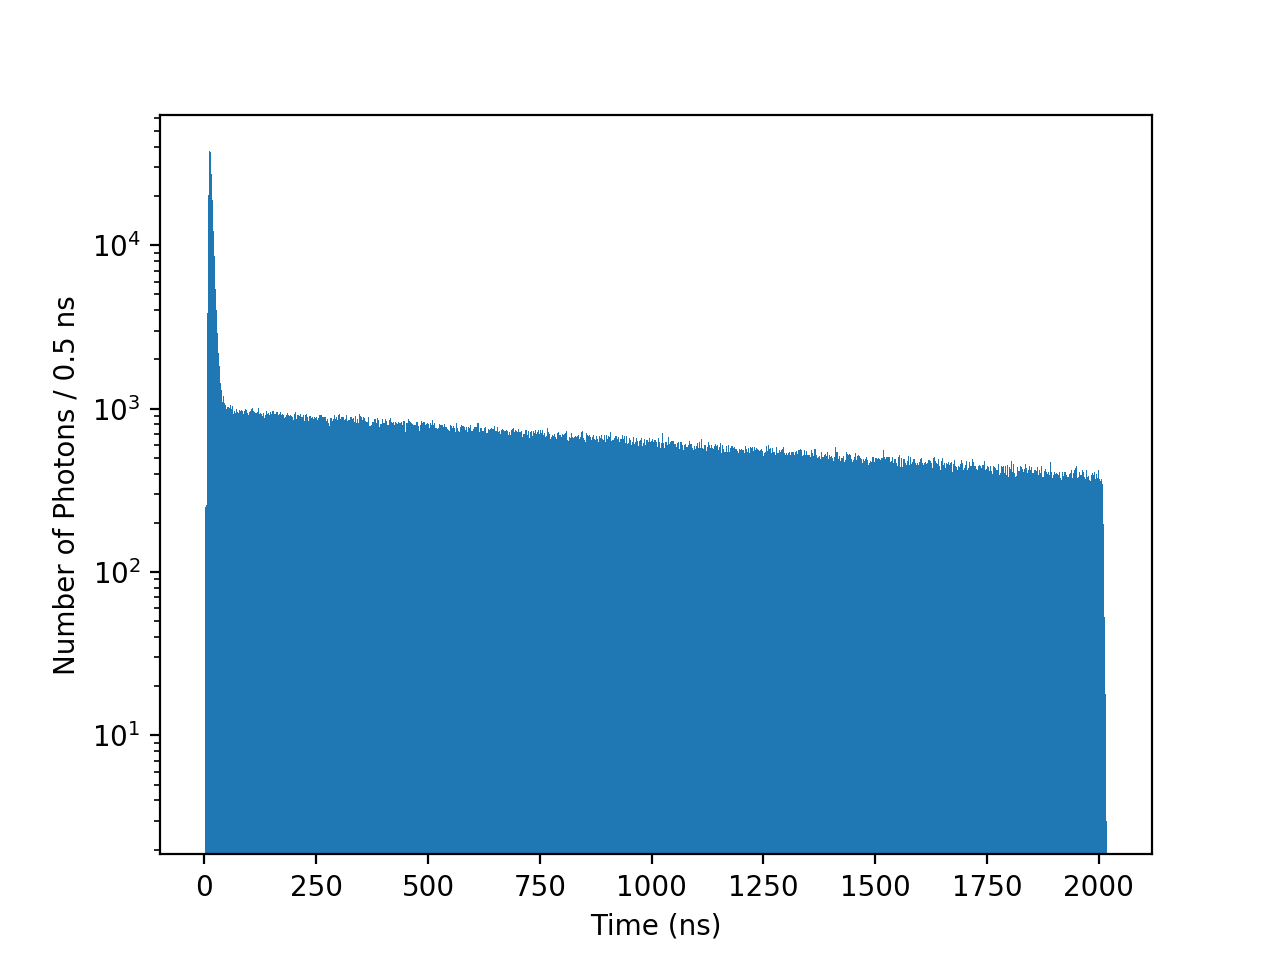

In [12]:
fig = plt.figure()
#count1, bins1, ignored1 = plt.hist(time_allphotons, 10000, density=False, weights = L)
count1, bins1, ignored1 = plt.hist(time_allphotons, 4000, density=False)
plt.yscale('log')
#plt.xlim(-10, 60)
#plt.ylim(1E-5, 0.1)
plt.xlabel("Time (ns)")
plt.ylabel("Number of Photons / 0.5 ns")
plt.show()

<IPython.core.display.Javascript object>


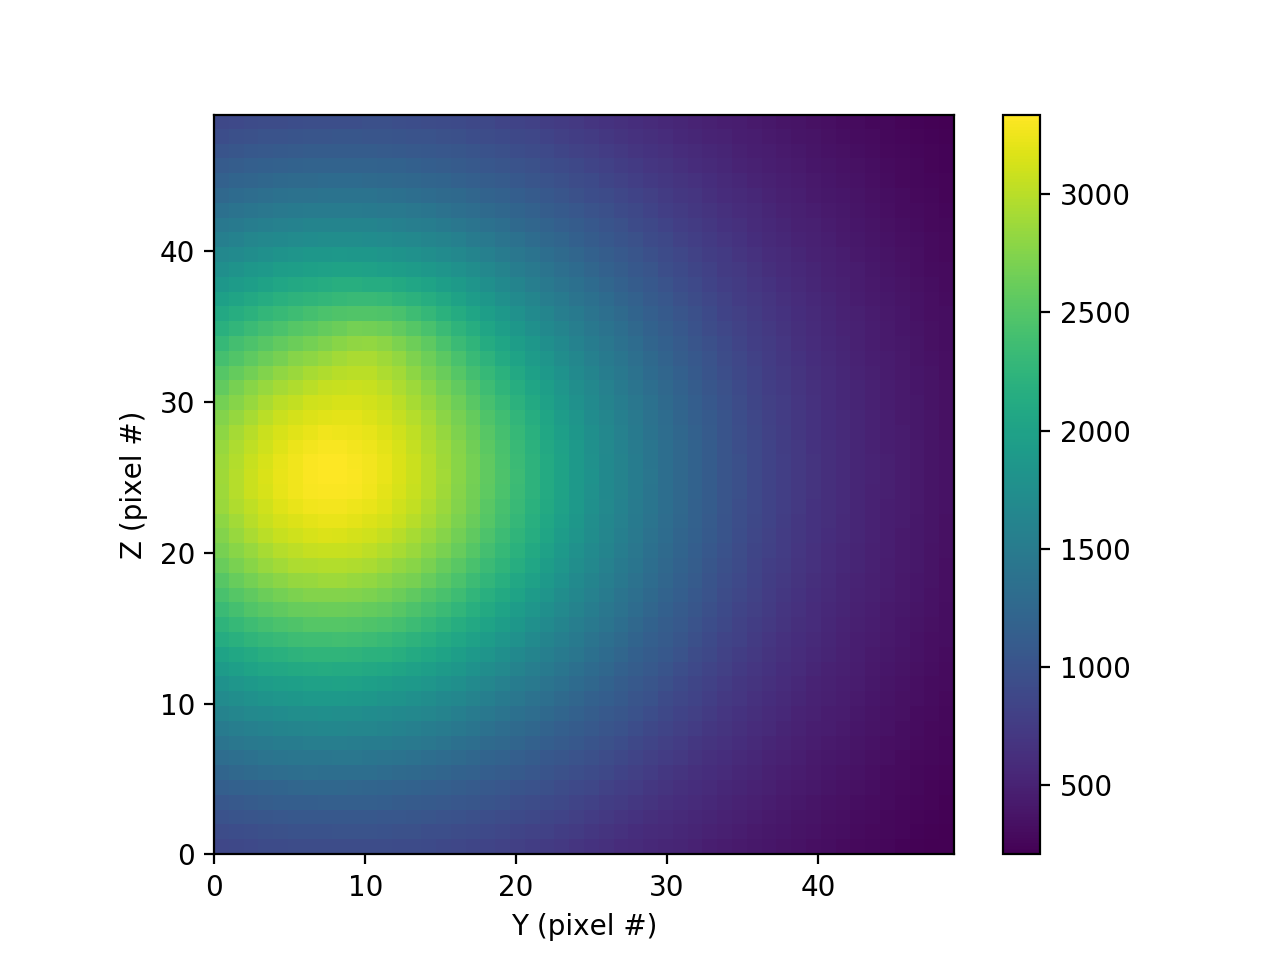

In [14]:
dy, dz = 1.0, 1.0
y = np.arange(0.0, nYPixels, dy) 
z = np.arange(0.0, nZPixels, dz) 

extent = np.min(y), np.max(y), np.min(z), np.max(z) 
#extent = 0,100,0,100

fig = plt.figure()
plt.xlabel("Y (pixel #)")
plt.ylabel("Z (pixel #)")
#plt.imshow(PixelMap, extent = extent, origin = 'lower', interpolation="nearest")
#plt.imshow(PixelMapYZ, origin = 'lower', interpolation = 'nearest', extent = extent, aspect=(nZPixels/nYPixels), norm=LogNorm(), vmin = 1, vmax = 10000)
plt.imshow(PixelMapYZ, origin = 'lower', interpolation = 'nearest', extent = extent, aspect=(nZPixels/nYPixels)) #, vmin = 1, vmax = 120)

#plt.gca().invert_yaxis()
plt.colorbar()
plt.savefig('LightIntersectionPoints-SemiAnalytic-YZ.png')

In [ ]:
### Define a color map so we can plot the amount of deposited energy 
viridis = cm.get_cmap('viridis', len(QEdep))
colors = viridis(QEdep)

#fig = plt.figure()
fig = plt.figure(figsize = (11, 5))
ax = fig.gca(projection='3d')
#colors = ('r', 'g', 'b', 'k')
my_cmap = plt.get_cmap('hsv')
#plt.scatter(XEdep, YEdep, ZEdep, marker = ".", color = colors)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
ax.set_xlim3d(-10,300)
ax.set_ylim3d(-10,200)
ax.set_zlim3d(-10,200)
p = ax.scatter(XEdep, YEdep, ZEdep , marker = ".", color = colors)
ax.view_init(elev=40., azim=+45)
fig.colorbar(p)
plt.savefig('AllPoints-XYZ.png')

In [ ]:
dy, dz = 1.0, 1.0
y = np.arange(0.0, nYPixels, dy) 
z = np.arange(0.0, nZPixels, dz) 

extent = np.min(y), np.max(y), np.min(z), np.max(z) 
#extent = 0,100,0,100

fig = plt.figure()
plt.xlabel("Y (pixel #)")
plt.ylabel("Z (pixel #)")
#plt.imshow(PixelMap, extent = extent, origin = 'lower', interpolation="nearest")
#plt.imshow(PixelTimeMapYZ, origin = 'lower', interpolation = 'nearest', extent = extent, aspect=(nZPixels/nYPixels), norm=LogNorm(),vmin = 1, vmax = 1000)
plt.imshow(PixelTimeMapYZ, origin = 'lower', interpolation = 'nearest', extent = extent, aspect=(nZPixels/nYPixels),vmin = 1, vmax = 50)

#plt.gca().invert_yaxis()
plt.colorbar()
plt.savefig('LightIntersectionPoints-SemiAnalytic-prompt-YZ.png')

In [ ]:
fig = plt.figure()
#count1, bins1, ignored1 = plt.hist(time_allphotons, 10000, density=False, weights = L)
count2, bins2, ignored2 = plt.hist(QEdep, 200, density=False)
plt.yscale('log')
#plt.xlim(-10, 60)
#plt.ylim(1E-5, 0.1)
plt.xlabel("Energy (GeV)")
plt.ylabel("")
plt.show()

In [ ]:
photons_per_pixel=[]
photons_per_pixel_prompt=[]
zloc = 0
yloc = 0
row = 0
column = 0

while zloc < zDimension:
    # loop over all the pixels in the y dimension for a given z dimension
    while yloc < yDimension:
        
        photons_per_pixel.append(PixelMapYZ[row,column])
        photons_per_pixel_prompt.append(PixelTimeMapYZ[row][column])
        yloc += 4.
        row+=1
    # Bump the z-location    
    zloc += 4.
    column +=1
    # zero the y location
    yloc = 0
    row = 0

In [ ]:
fig = plt.figure()
#count1, bins1, ignored1 = plt.hist(time_allphotons, 10000, density=False, weights = L)
count4, bins4, ignored4 = plt.hist(photons_per_pixel_prompt, 50, density=False, label = 'Photons w/ t < 50 ns')
count3, bins3, ignored3 = plt.hist(photons_per_pixel, 100, density=False, label = 'All Photons')
#plt.yscale('log')
#plt.xlim(-10, 60)
#plt.ylim(1E-5, 0.1)
plt.xlabel("Number of Photons / Pixel")
plt.ylabel("Number of Pixels")
plt.legend()
plt.show()